In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams
import h5py
import seaborn as sns
from scipy.special import logit
from scipy.special import expit
from scipy.interpolate import RegularGridInterpolator
from pylab import rcParams
import sys
import torch

import sys
sys.path.append('../')
from populations.bbh_models import read_hdf5
from populations.Flowsclass_dev import FlowModel

PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


glasflow is using its own internal version of nflows


In [3]:
#flags/inputs:
param = ['mchirp','q', 'chieff', 'z']
no_params = len(param)
channel_label = 'SMT'

channel_ids = {'CE':0, 'CHE':1,'GC':2,'NSC':3, 'SMT':4}
channel_id = channel_ids[channel_label] #will be 0, 1, 2, 3, or 4
chi_b = [0.0,0.1,0.2,0.5]
alpha_CE = [0.2,0.5,1.0,2.,5.]
channel_samples = [4e6,864124,896611,582961, 4e6]
no_binaries = int(channel_samples[channel_id])
batch_size = 10000
total_hps=4

models_path ='/Users/stormcolloms/Documents/PhD/Project_work/OneChannel_Flows/models_reduced.hdf5'
popsynth_outputs = read_hdf5(models_path, channel_label) # read all data from hdf5 file

models_dict = dict.fromkeys(popsynth_outputs.keys())
weights_dict = dict.fromkeys(popsynth_outputs.keys())


for key in popsynth_outputs.keys():
    models_dict[key] = popsynth_outputs[key][param]
    weights_dict[key]= popsynth_outputs[key]['weight']


In [4]:
#check that these distributions are the same between the whole (transformed distribution), batch, and the same for validation data
#no_trans, no_neurons, training_inputs, cond_inputs,no_binaries, batch_size, total_hps, RNVP=True, num_bins=4, device="cpu"):
flow = FlowModel(channel_label, popsynth_outputs, param)
weighted_flow = FlowModel(channel_label, popsynth_outputs, param)


In [5]:
flow.load_model('./', channel_label)
weighted_flow.load_model('./cosmo_weights/', channel_label)

## Unweighted flow distributions - nonCE

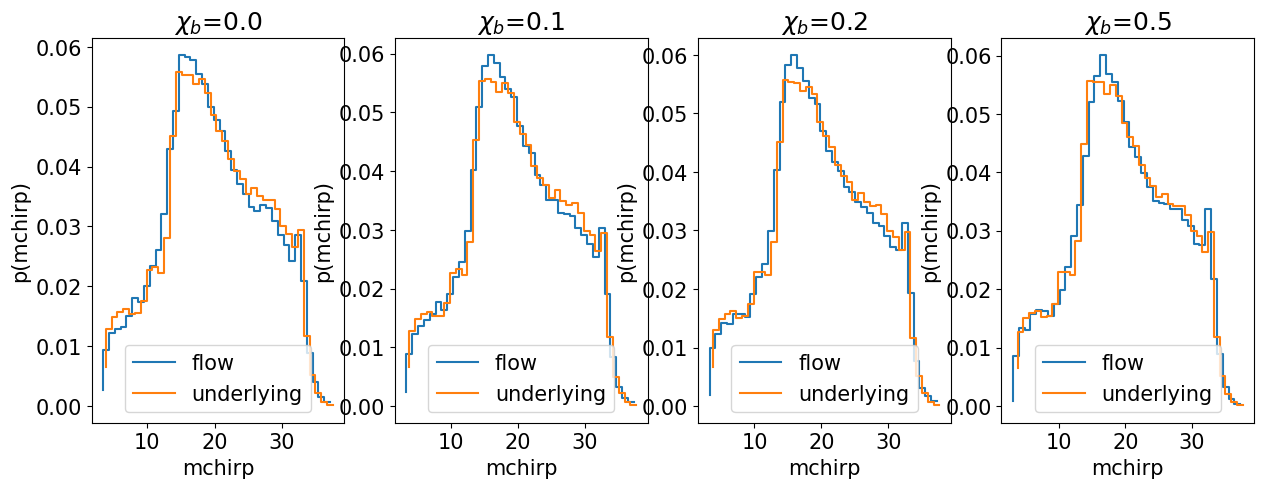

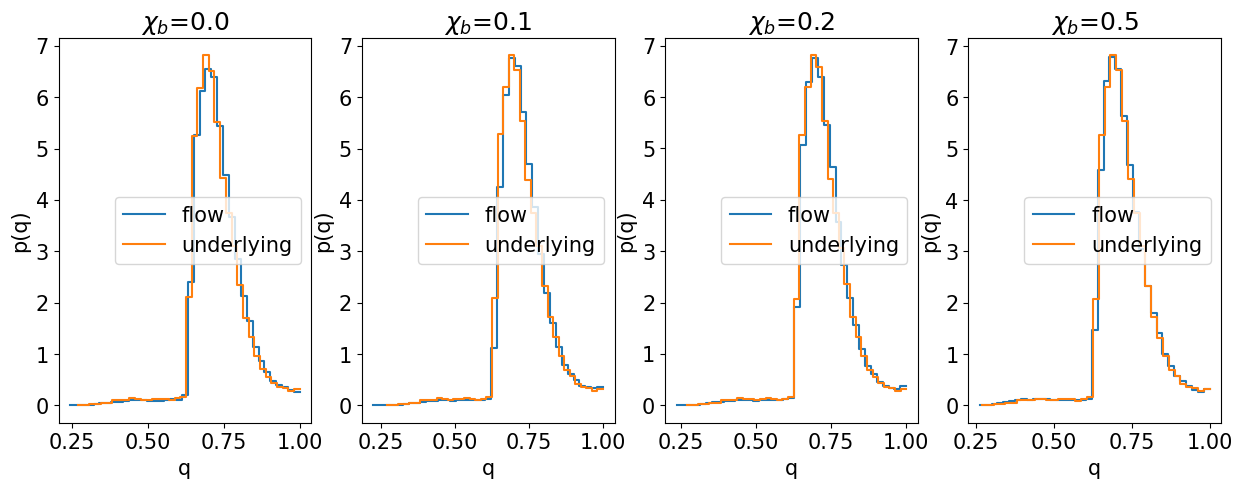

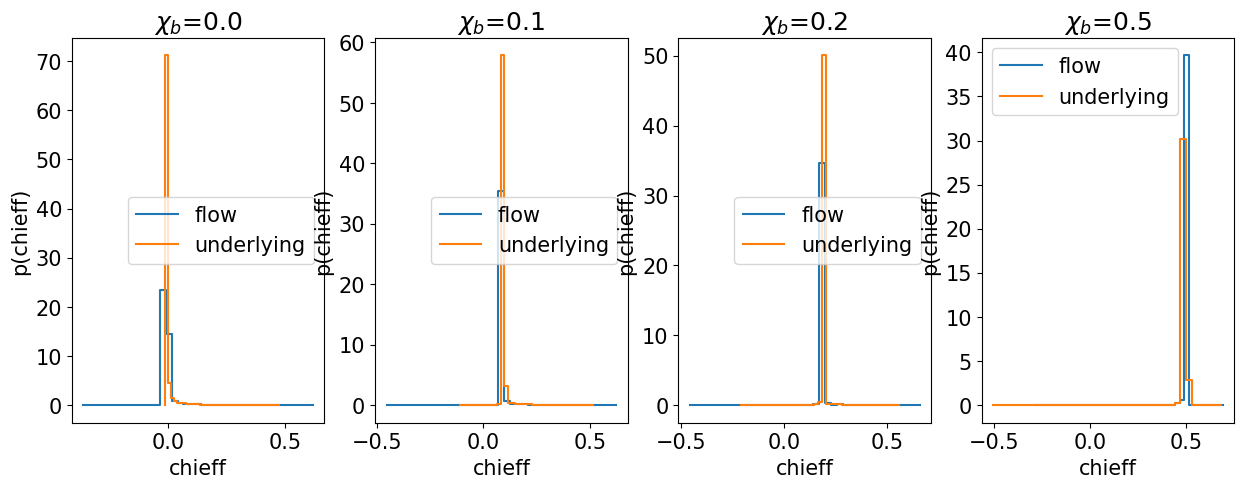

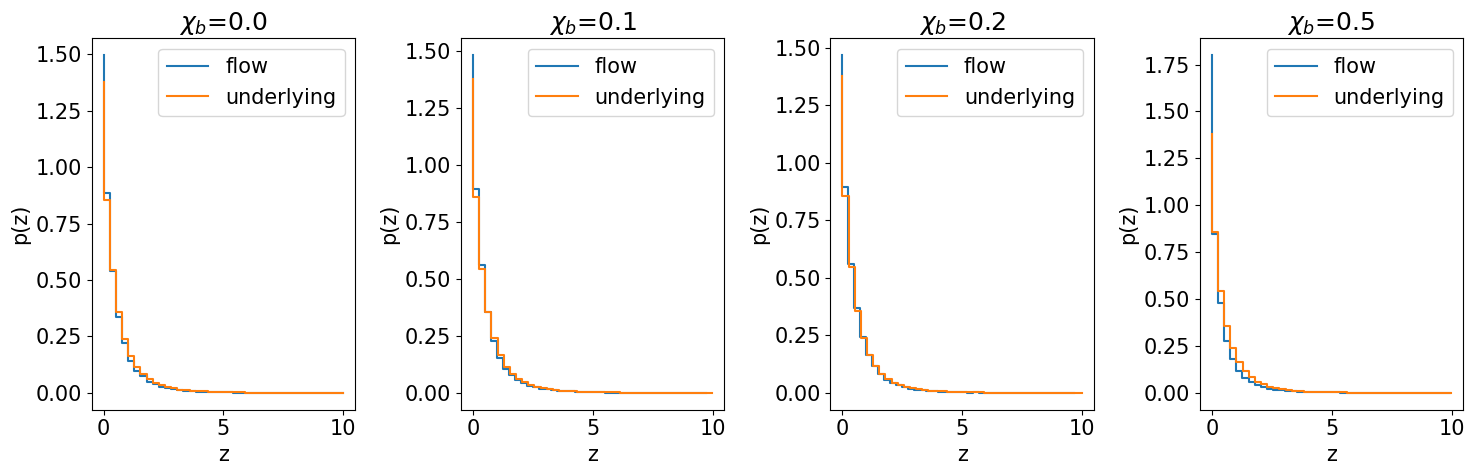

In [77]:
plt.rcParams["figure.figsize"] = (15,5)
no_samples = 100000
no_bins = 40

fig_mchirp, ax_m = plt.subplots(1,4)
fig_q, ax_q = plt.subplots(1,4)
fig_c, ax_c = plt.subplots(1,4)
fig_z, ax_z = plt.subplots(1,4)

for chi_b_id, xb in enumerate(chi_b):
    flow_samples_stack = flow.flow.easy_sample(no_samples, np.array([xb]))
    flow_mchirp = flow.expistic(flow_samples_stack[:,0], flow.mappings[0], flow.mappings[1])
    flow_q = flow.expistic(flow_samples_stack[:,1], flow.mappings[2])
    flow_chieff = np.tanh(flow_samples_stack[:,2])
    flow_z = flow.expistic(flow_samples_stack[:,3], flow.mappings[4], flow.mappings[5])

    mapped_flow_samples = [flow_mchirp,flow_q,flow_chieff,flow_z]

    for i, ax in enumerate([ax_m,ax_q,ax_c,ax_z]):
        flow_distr, bin_edges = np.histogram(mapped_flow_samples[i], bins=no_bins, density=True)
        known_distr, bin_edges_known =np.histogram(models_dict[chi_b_id][:][param[i]], bins=no_bins, density=True)
        ax[chi_b_id].step(np.linspace(bin_edges[0],bin_edges[-1],no_bins),flow_distr, label='flow')
        ax[chi_b_id].step(np.linspace(bin_edges_known[0],bin_edges_known[-1],no_bins),known_distr,label='underlying')
        ax[chi_b_id].set_title(fr'$\chi_b$={xb}')
        ax[chi_b_id].set_xlabel(f'{param[i]}')
        ax[chi_b_id].set_ylabel(f'p({param[i]})')
        ax[chi_b_id].legend()
        plt.tight_layout()

## Weighted Flow distributions - nonCE

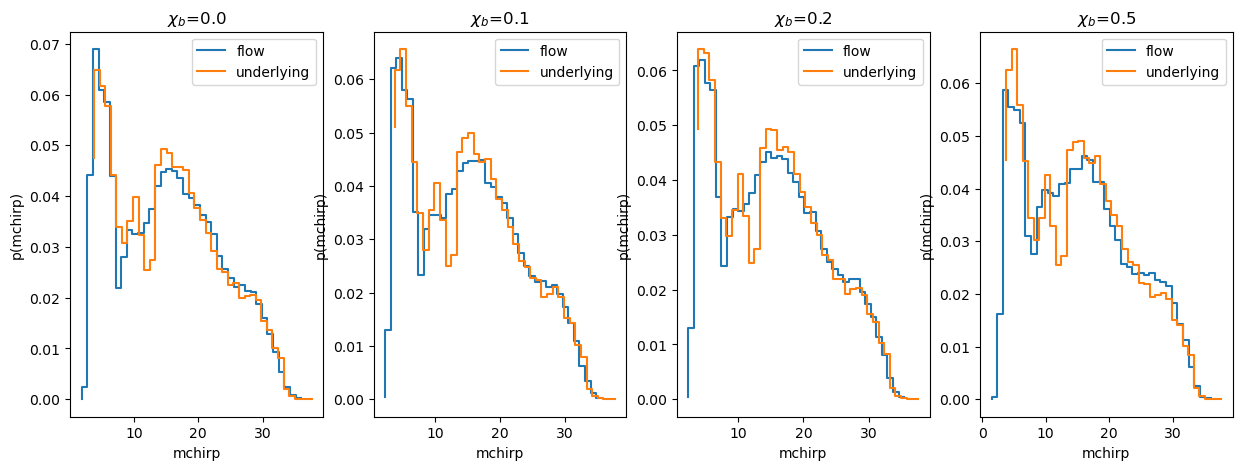

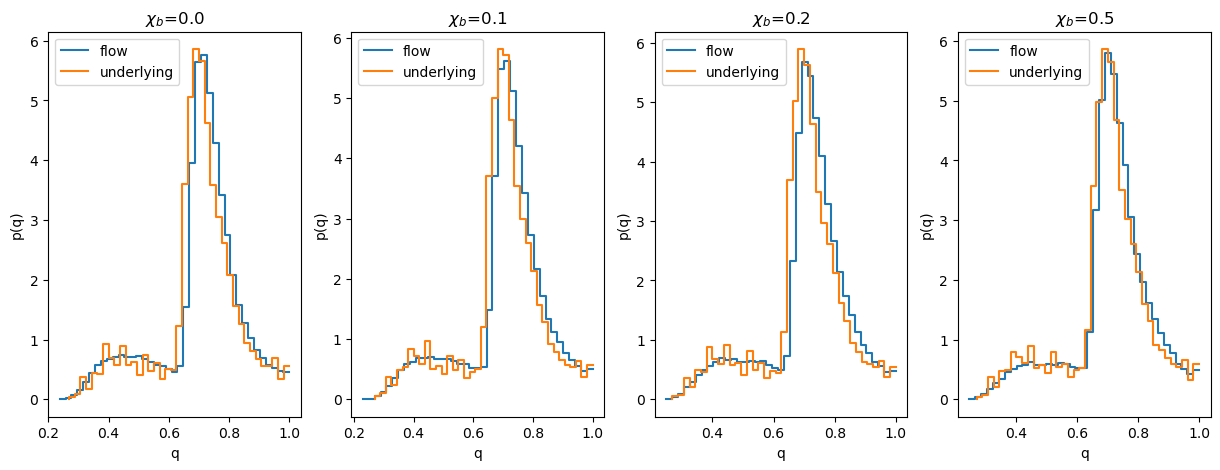

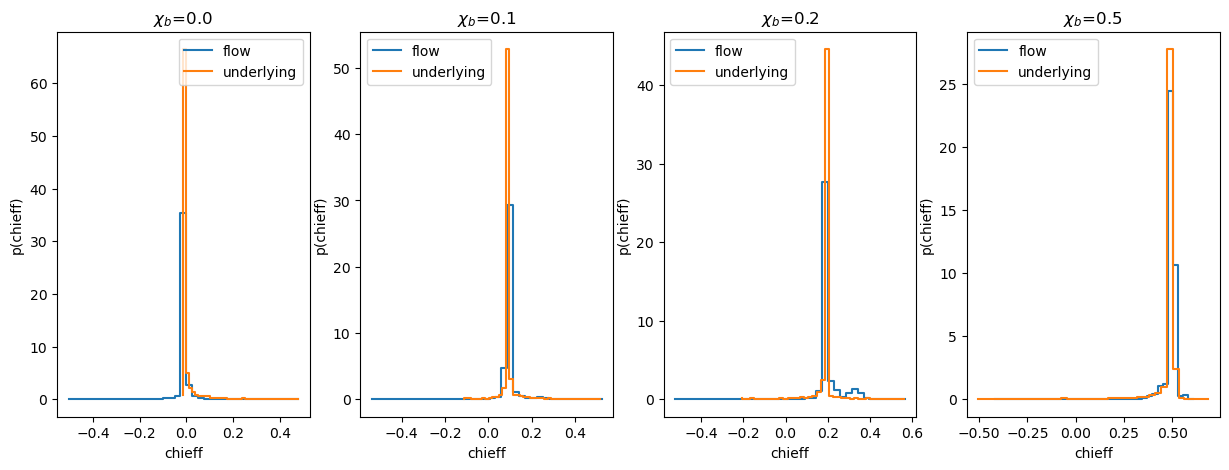

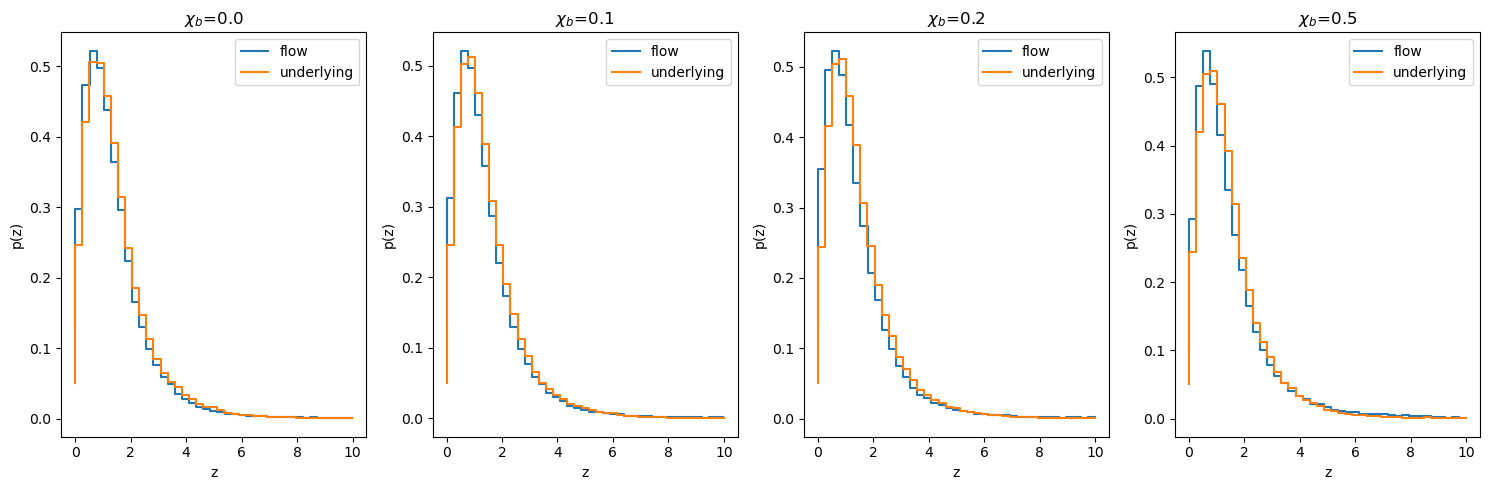

In [6]:
plt.rcParams["figure.figsize"] = (15,5)
no_samples = 100000
no_bins = 40

fig_mchirp, ax_m = plt.subplots(1,4)
fig_q, ax_q = plt.subplots(1,4)
fig_c, ax_c = plt.subplots(1,4)
fig_z, ax_z = plt.subplots(1,4)

for chi_b_id, xb in enumerate(chi_b):
    flow_samples_stack = weighted_flow.flow.easy_sample(no_samples, np.array([xb]))
    flow_mchirp = weighted_flow.expistic(flow_samples_stack[:,0], weighted_flow.mappings[0], weighted_flow.mappings[1])
    flow_q = weighted_flow.expistic(flow_samples_stack[:,1], weighted_flow.mappings[2])
    flow_chieff = np.tanh(flow_samples_stack[:,2])
    flow_z = weighted_flow.expistic(flow_samples_stack[:,3], weighted_flow.mappings[4], weighted_flow.mappings[5])

    mapped_flow_samples = [flow_mchirp,flow_q,flow_chieff,flow_z]

    for i, ax in enumerate([ax_m,ax_q,ax_c,ax_z]):
        flow_distr, bin_edges = np.histogram(mapped_flow_samples[i], bins=no_bins, density=True)
        known_distr, bin_edges_known =np.histogram(models_dict[chi_b_id][:][param[i]], bins=no_bins, density=True, weights=weights_dict[chi_b_id])
        ax[chi_b_id].step(np.linspace(bin_edges[0],bin_edges[-1],no_bins),flow_distr, label='flow')
        ax[chi_b_id].step(np.linspace(bin_edges_known[0],bin_edges_known[-1],no_bins),known_distr,label='underlying')
        ax[chi_b_id].set_title(fr'$\chi_b$={xb}')
        ax[chi_b_id].set_xlabel(f'{param[i]}')
        ax[chi_b_id].set_ylabel(f'p({param[i]})')
        ax[chi_b_id].legend()
        plt.tight_layout()

## Unweighted distributions - CE

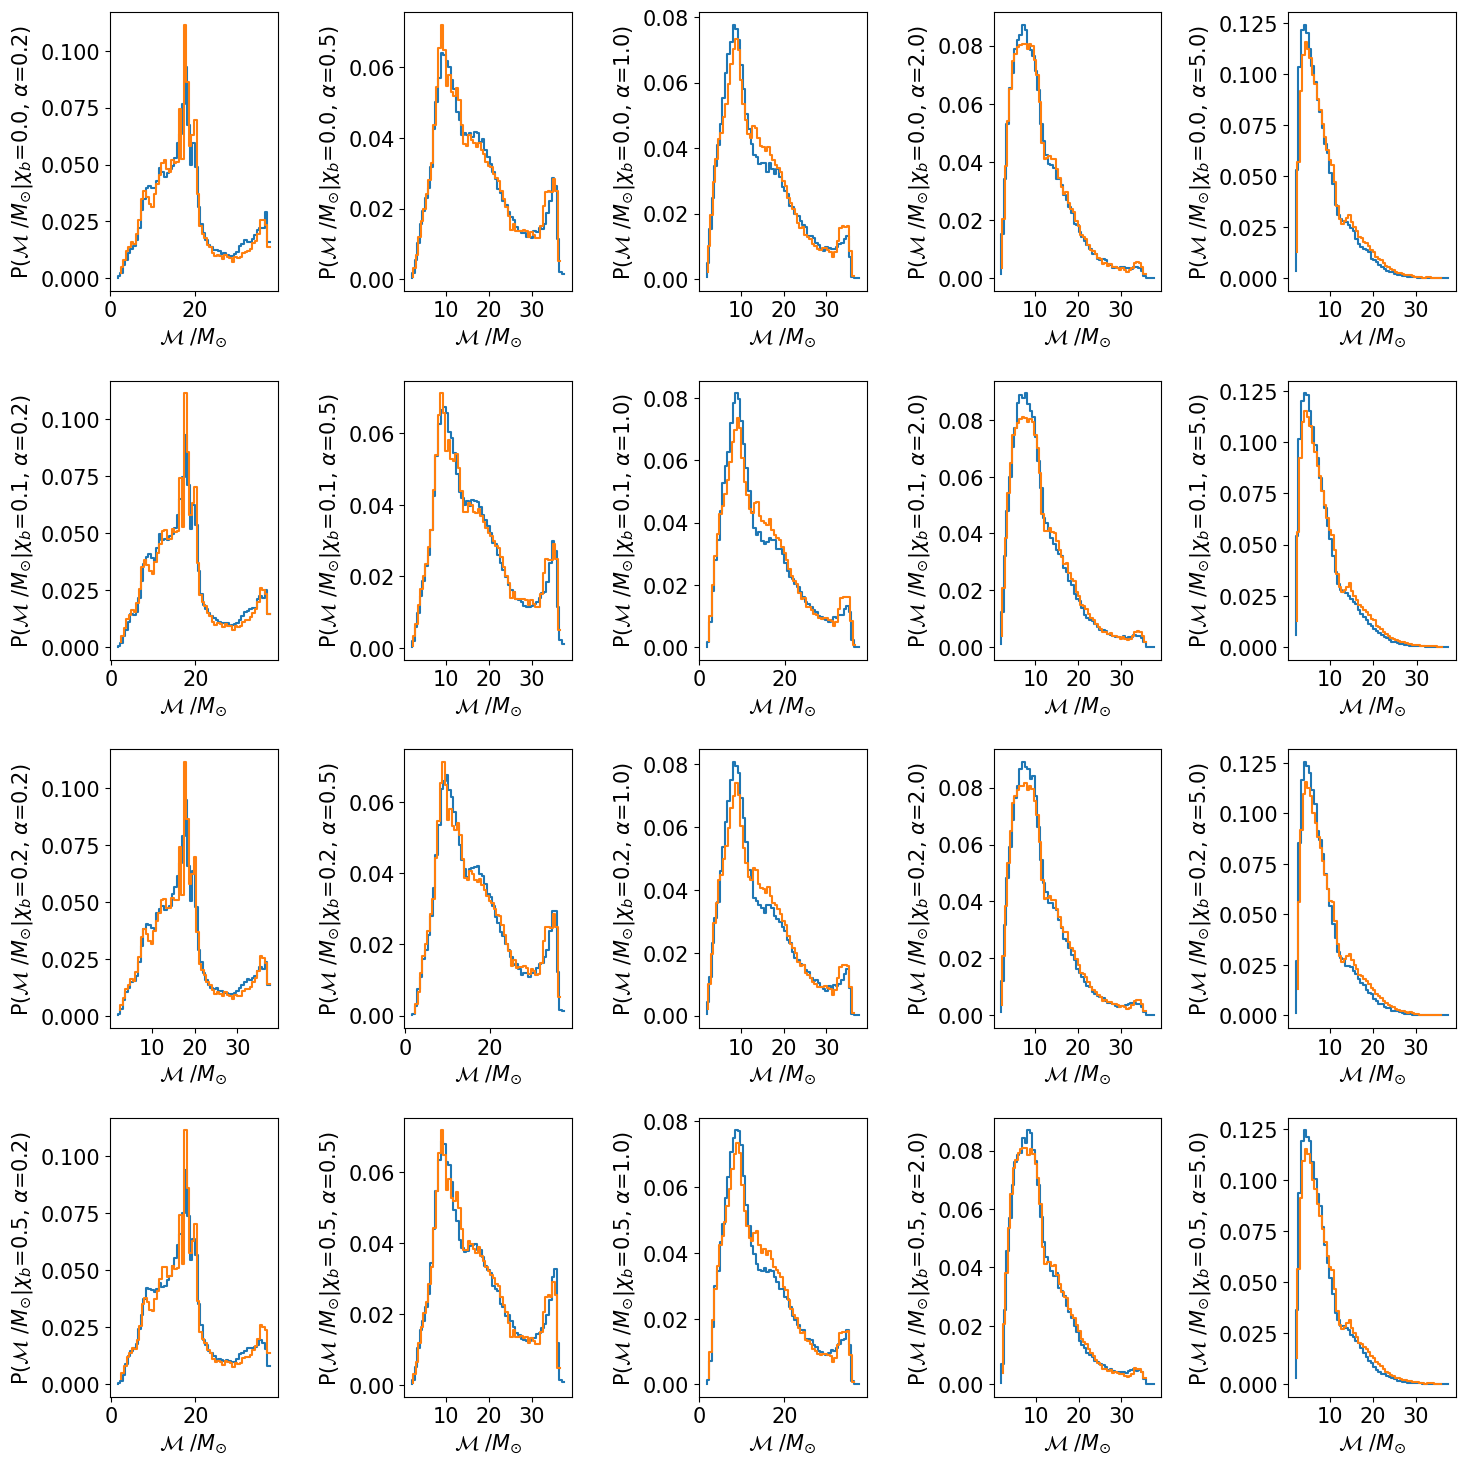

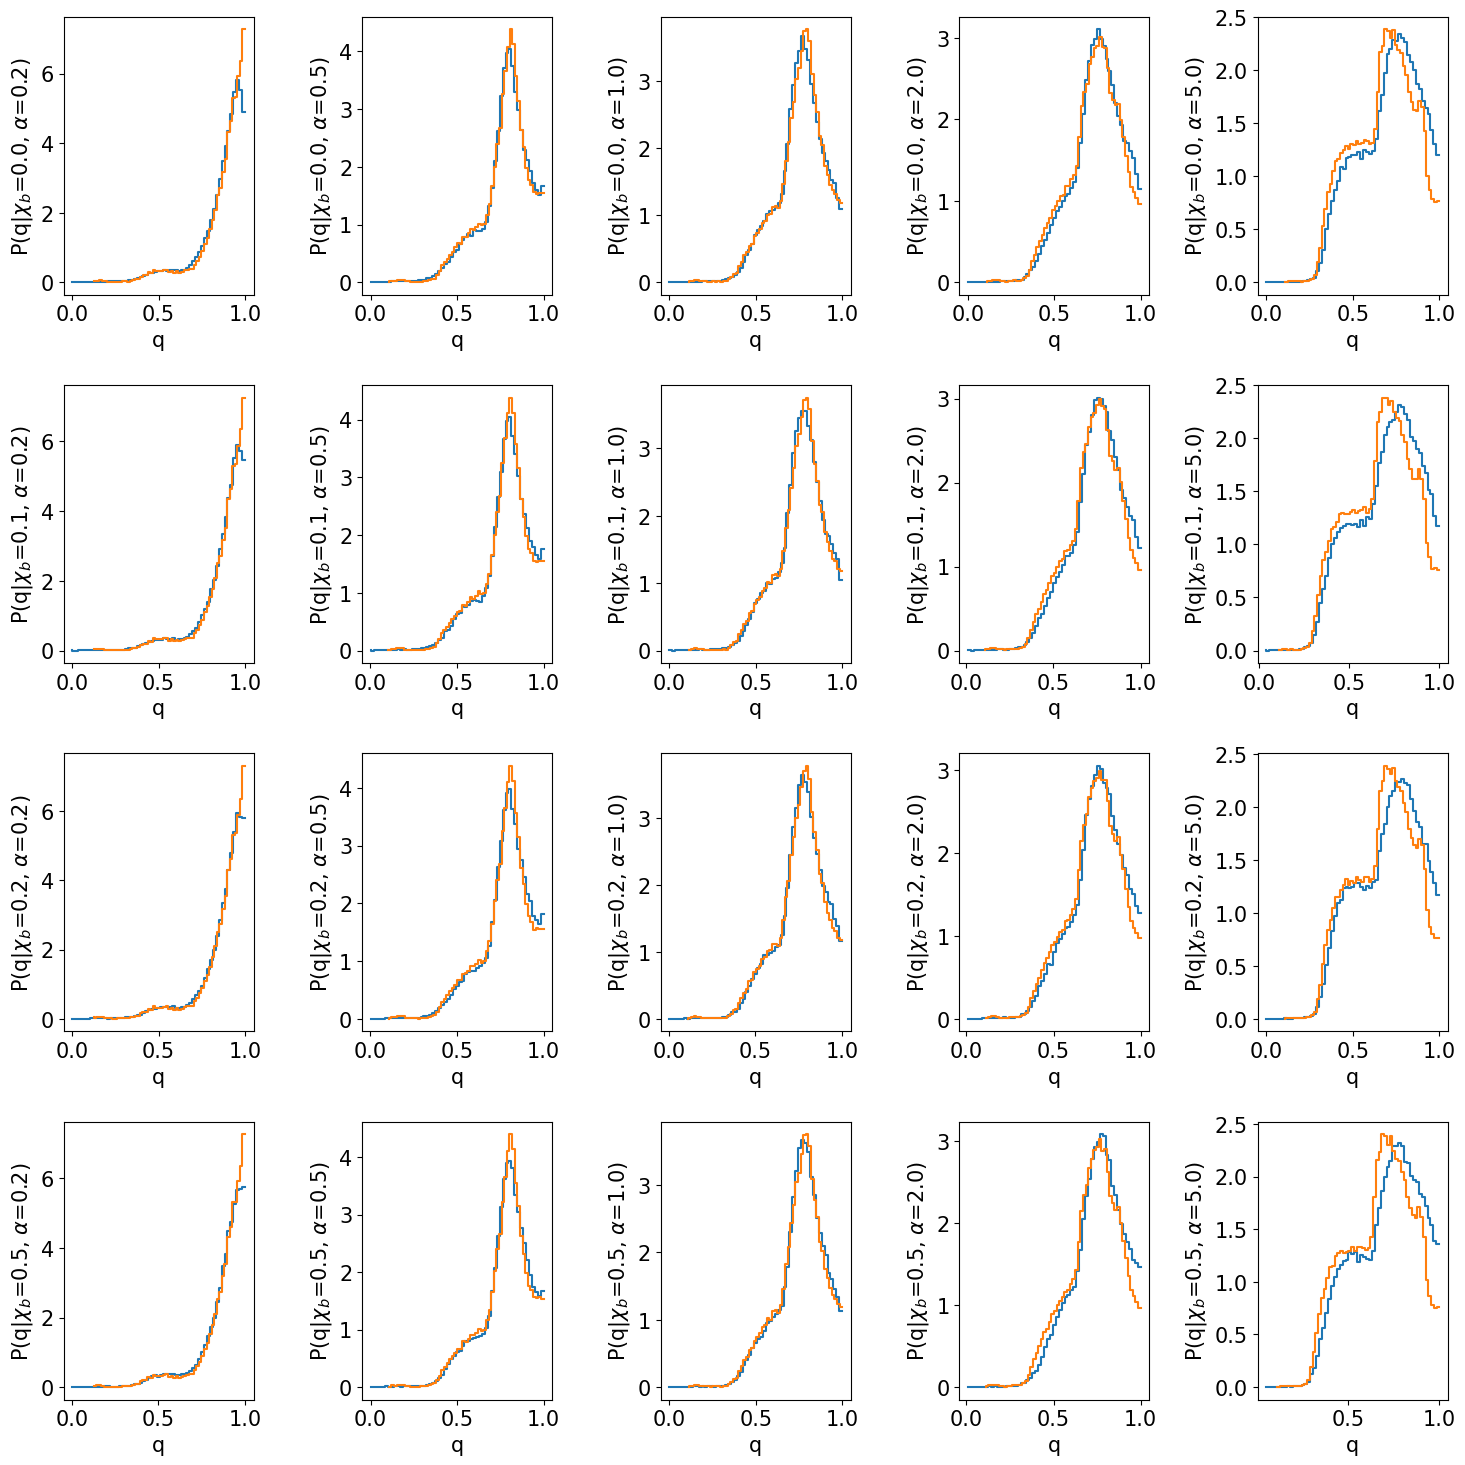

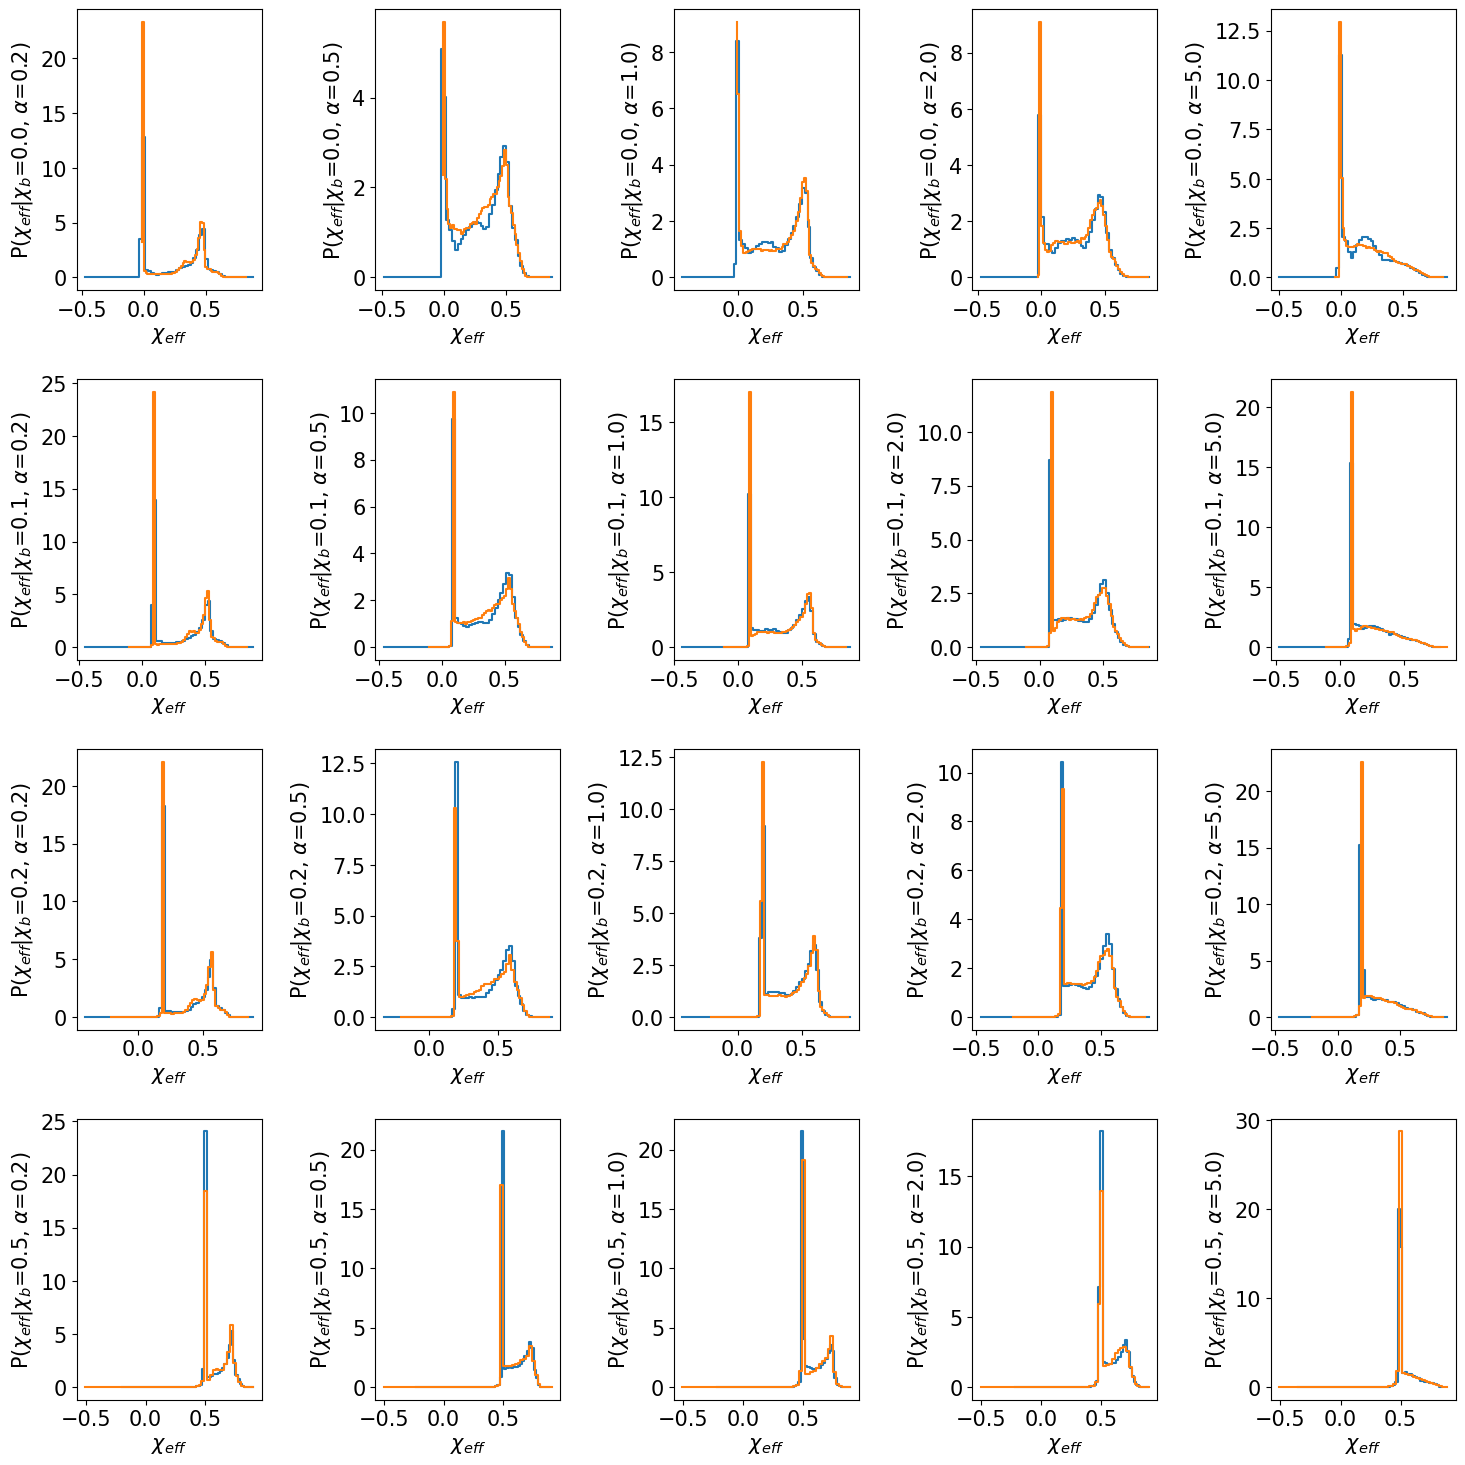

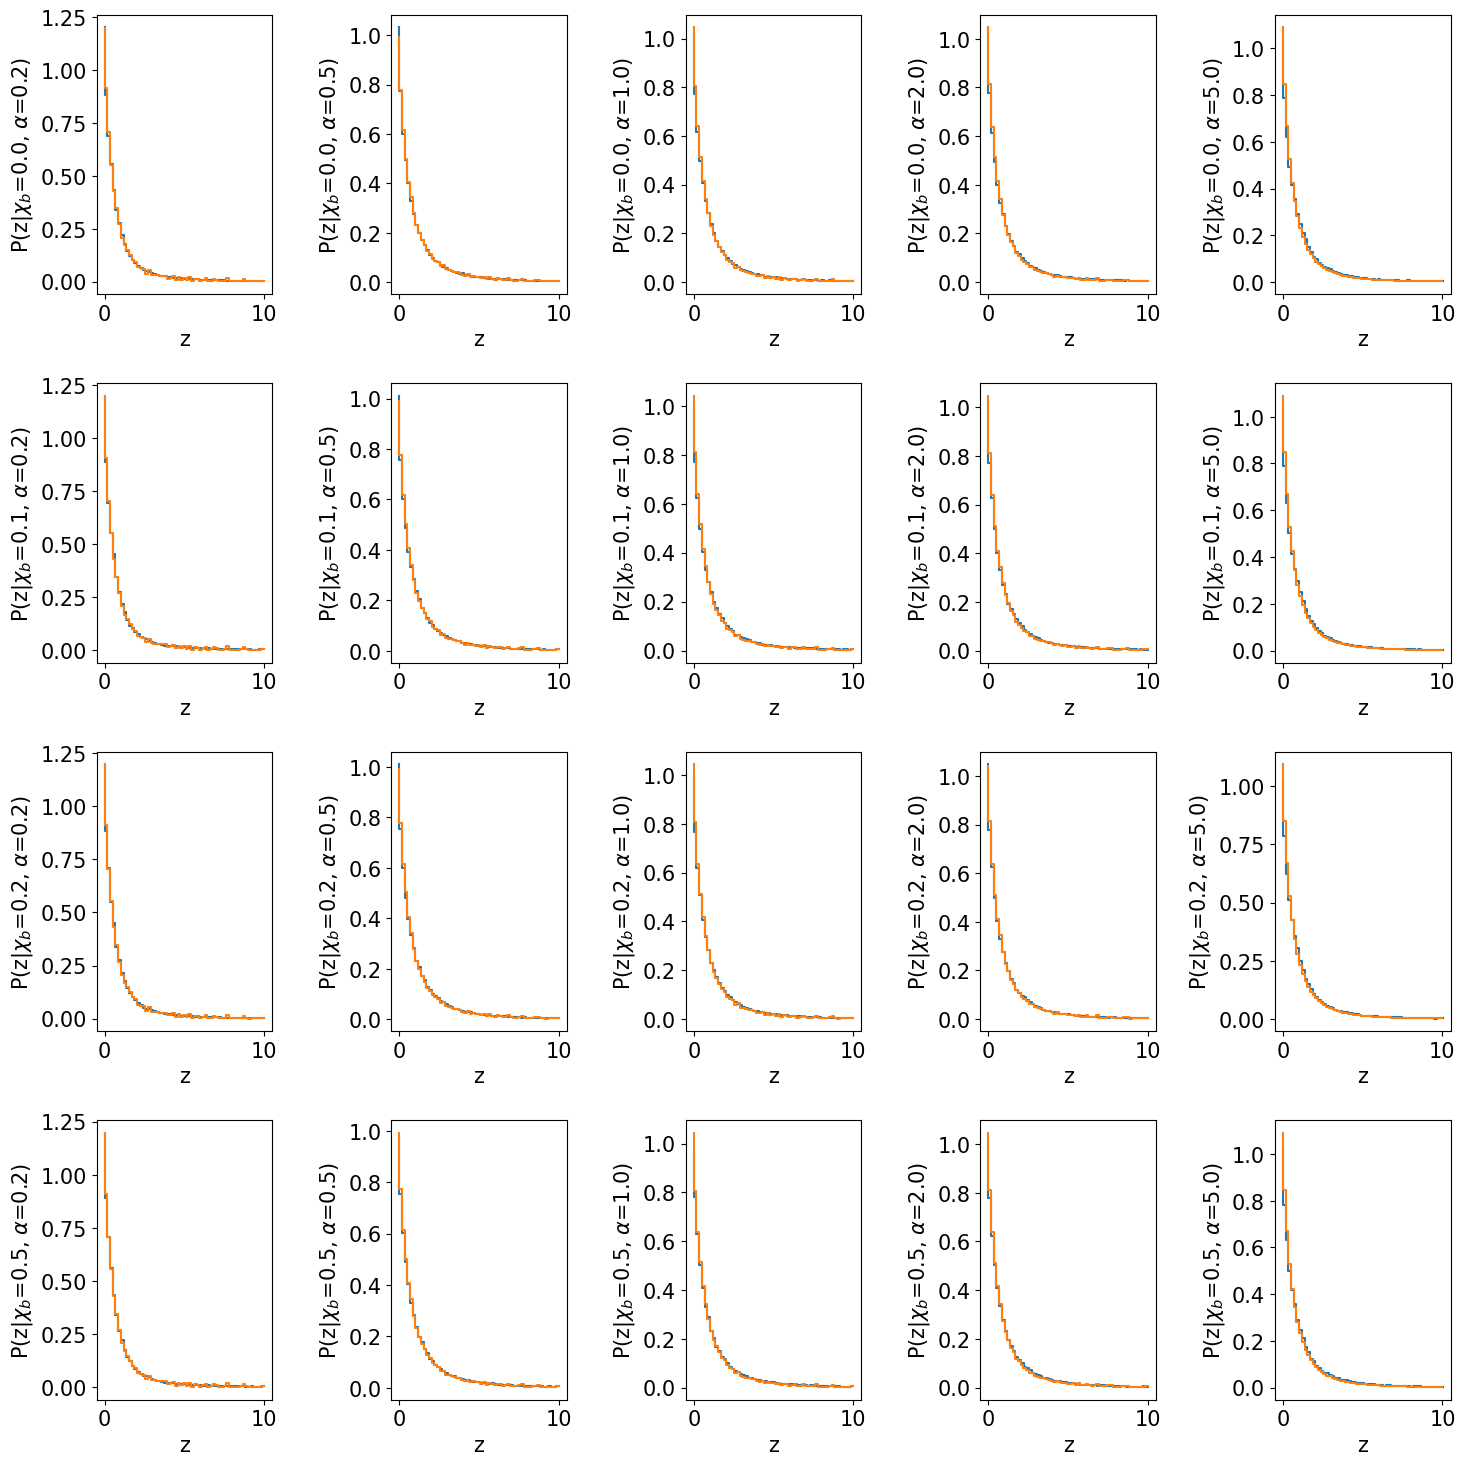

In [42]:
plt.rcParams["figure.figsize"] = (15,15)
plt.rcParams.update({'font.size': 15})
no_samples = 100000
no_bins = 60

fig_mchirp, ax_m = plt.subplots(4,5)
fig_q, ax_q = plt.subplots(4,5)
fig_c, ax_c = plt.subplots(4,5)
fig_z, ax_z = plt.subplots(4,5)

param_label = ['$\mathcal{M}$ /$M_{\odot}$','q', '$\chi_{eff}$', 'z']

for chi_b_id, xb in enumerate(chi_b):
    for alpha_id, a in enumerate(alpha_CE):
        flow_samples_stack = flow.flow.easy_sample(no_samples, np.array([xb,a]))
        flow_mchirp = flow.expistic(flow_samples_stack[:,0], flow.mappings[0], flow.mappings[1])
        flow_q = flow.expistic(flow_samples_stack[:,1], flow.mappings[2])
        flow_chieff = np.tanh(flow_samples_stack[:,2])
        flow_z = flow.expistic(flow_samples_stack[:,3], flow.mappings[4], flow.mappings[5])

        mapped_flow_samples = [flow_mchirp,flow_q,flow_chieff,flow_z]

        for i, ax in enumerate([ax_m,ax_q,ax_c,ax_z]):
            flow_distr, bin_edges = np.histogram(mapped_flow_samples[i], bins=no_bins, density=True)
            known_distr, bin_edges_known =np.histogram(models_dict[(chi_b_id,alpha_id)][:][param[i]], bins=no_bins, density=True)
            ax[chi_b_id,alpha_id].step(np.linspace(bin_edges[0],bin_edges[-1],no_bins),flow_distr, label='flow')
            ax[chi_b_id,alpha_id].step(np.linspace(bin_edges_known[0],bin_edges_known[-1],no_bins),known_distr,label='underlying')
            #ax[chi_b_id,alpha_id].set_title(fr'$\chi_b$={xb} and $\alpha$={a}')
            ax[chi_b_id,alpha_id].set_xlabel(fr'{param_label[i]}')
            ax[chi_b_id,alpha_id].set_ylabel(fr'P({param_label[i]}|$\chi_b$={xb}, $\alpha$={a})')
            #ax[chi_b_id,alpha_id].legend()
            fig_mchirp.tight_layout(pad=1.3)
            fig_c.tight_layout(pad=1.3)
            fig_q.tight_layout(pad=1.3)
            fig_z.tight_layout(pad=1.3)

## Weighted Distributions - CE

In [1]:
plt.rcParams["figure.figsize"] = (15,15)
plt.rcParams.update({'font.size': 15})
no_samples = 100000
no_bins = 60

fig_mchirp, ax_m = plt.subplots(4,5)
fig_q, ax_q = plt.subplots(4,5)
fig_c, ax_c = plt.subplots(4,5)
fig_z, ax_z = plt.subplots(4,5)

param_label = ['$\mathcal{M}$ /$M_{\odot}$','q', '$\chi_{eff}$', 'z']

for chi_b_id, xb in enumerate(chi_b):
    for alpha_id, a in enumerate(alpha_CE):
        flow_samples_stack = weighted_flow.flow.easy_sample(no_samples, np.array([xb,a]))
        flow_mchirp = weighted_flow.expistic(flow_samples_stack[:,0], weighted_flow.mappings[0], weighted_flow.mappings[1])
        flow_q = weighted_flow.expistic(flow_samples_stack[:,1], weighted_flow.mappings[2])
        flow_chieff = np.tanh(flow_samples_stack[:,2])
        flow_z = weighted_flow.expistic(flow_samples_stack[:,3], weighted_flow.mappings[4], weighted_flow.mappings[5])

        mapped_flow_samples = [flow_mchirp,flow_q,flow_chieff,flow_z]

        for i, ax in enumerate([ax_m,ax_q,ax_c,ax_z]):
            flow_distr, bin_edges = np.histogram(mapped_flow_samples[i], bins=no_bins, density=True)
            known_distr, bin_edges_known =np.histogram(models_dict[(chi_b_id,alpha_id)][:][param[i]], bins=no_bins, density=True, weights=weights_dict[(chi_b_id,alpha_id)][:])
            ax[chi_b_id,alpha_id].step(np.linspace(bin_edges[0],bin_edges[-1],no_bins),flow_distr, label='flow')
            ax[chi_b_id,alpha_id].step(np.linspace(bin_edges_known[0],bin_edges_known[-1],no_bins),known_distr,label='underlying')
            #ax[chi_b_id,alpha_id].set_title(fr'$\chi_b$={xb} and $\alpha$={a}')
            ax[chi_b_id,alpha_id].set_xlabel(fr'{param_label[i]}')
            ax[chi_b_id,alpha_id].set_ylabel(fr'P({param_label[i]}|$\chi_b$={xb}, $\alpha$={a})')
            #ax[chi_b_id,alpha_id].legend()
            fig_mchirp.tight_layout(pad=1.3)
            fig_c.tight_layout(pad=1.3)
            fig_q.tight_layout(pad=1.3)
            fig_z.tight_layout(pad=1.3)

NameError: name 'plt' is not defined